# Método ML: Decision Tree Regression with Bagging
## Time serie: Pozo Izquierdo ME
### height from the ground:40 mtos.
Field: wind

In [7]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics.regression import mean_squared_error
from sklearn.metrics.regression import mean_absolute_error
from sklearn.externals import joblib

In [2]:
# cargamos el horizonte de la serie a predecir con las features
path = '../../database/torrePozoIzquierdo_JUL_AGO_2004/torreME_features/pozo_izquierdo_torre_me_h_1.csv'
df_v40_hour_h1 = pd.read_csv(path, delimiter=';')
df_v40_hour_h1.head()

,target_date,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,target
0,2004-07-01 00:10:00,9.6,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5
1,2004-07-01 00:11:00,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2
2,2004-07-01 00:12:00,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3
3,2004-07-01 00:13:00,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7
4,2004-07-01 00:14:00,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7,12.5


In [3]:
def dataframe_split(df):
    """
    Split a pandas dataframe in three dataframe. 
    :df: pandas dataframe 
    :return: a dictionary where the value of the key is a pandas dataframe.
             each dataframe has a time measure, features and the target variable.
    """
    # split the original dataframe in two dataframe. 
    # 80 % train and 20 % test set.
    train_size = int((df.shape[0] * 80) / 100)
    # Test set.
    df_train_set = df.iloc[0:train_size]
    df_test_set = df.iloc[train_size:]
    # Split train set in train and validation set using the method of
    # scikit-learn 'train_test_split'.
    df_train_set, df_validation_set = train_test_split(df_train_set, test_size=0.2)
    
    return {'train_set' : df_train_set,
            'validation_set': df_validation_set,
            'test_set': df_test_set}

In [4]:
data = dataframe_split(df_v40_hour_h1)
# dfs: train, validation and test set
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [5]:
# bug: the original time seria has null values.
train_set = train_set.fillna(0.0)
validation_set = validation_set.fillna(0.0)

## Decisition Tree Regression Bagging

### Hyperparameters

In [6]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]

In [8]:
base_estimator = DecisionTreeRegressor(max_depth=6)
n_estimators = 10

model = BaggingRegressor(base_estimator, n_estimators=n_estimators)

In [9]:
model.fit(features_train_set, target_train_set)

/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [10]:
features_test_set = test_set[features_columns]
predicted = model.predict(features_test_set)

In [12]:
df_target = test_set[['target_date', 'target']]
df_target.set_index(['target_date'], inplace=True)
df_target.head(5)

,target
target_date,
2004-08-19 21:36:00,11.7
2004-08-19 21:37:00,12.2
2004-08-19 21:38:00,11.2
2004-08-19 21:39:00,10.2
2004-08-19 21:40:00,10.1


In [13]:
df_target.loc[:, 'predicted'] = predicted

/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [15]:
 df_target.head(10)

,target,predicted
target_date,,
2004-08-19 21:36:00,11.7,11.223547
2004-08-19 21:37:00,12.2,11.491558
2004-08-19 21:38:00,11.2,12.073399
2004-08-19 21:39:00,10.2,11.319760
2004-08-19 21:40:00,10.1,10.838829
2004-08-19 21:41:00,9.8,10.767662
2004-08-19 21:42:00,9.4,10.129004
2004-08-19 21:43:00,10.8,9.832145
2004-08-19 21:44:00,10.8,10.604444


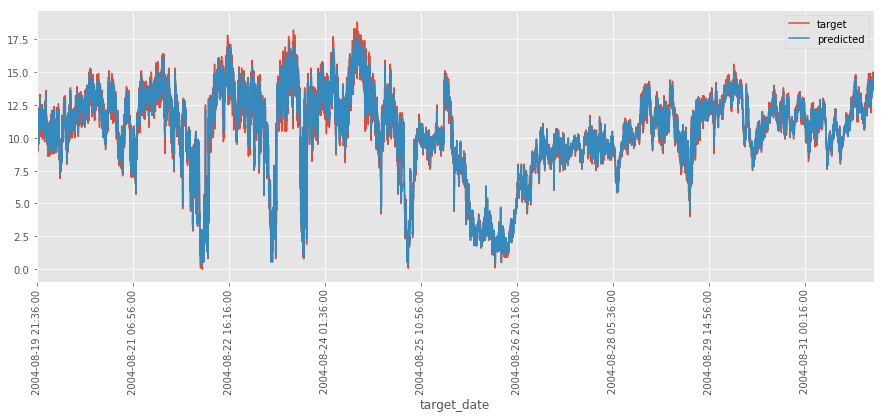

In [16]:
df_target.plot(figsize=(15,5), rot=90)

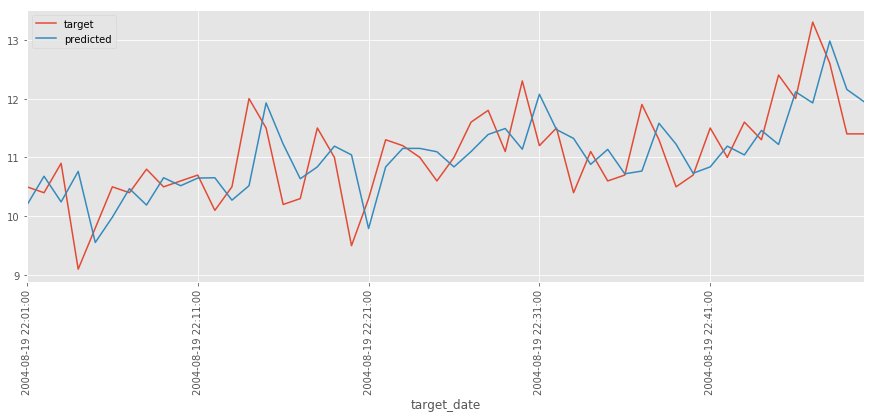

In [17]:
df_target.loc['2004-08-19 22:01:00':'2004-08-19 22:50:00'].plot(figsize=(15,5), rot=90)

In [18]:
df_target.loc[:,'bias'] = df_target['target'] - df_target['predicted']

/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


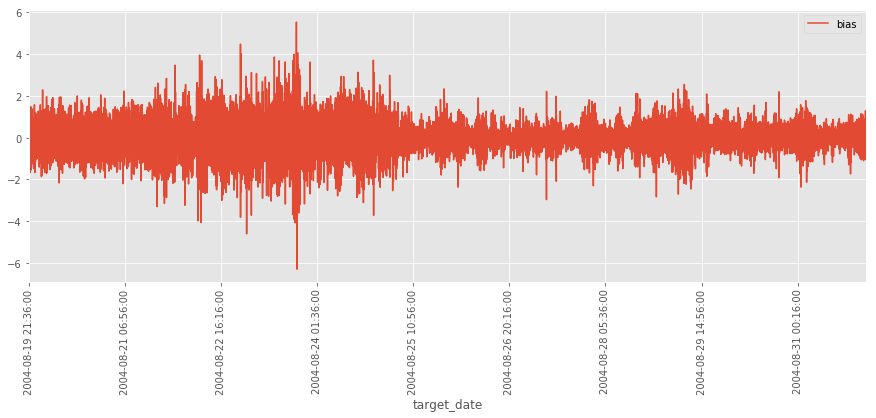

In [19]:
df_target[['bias']].plot(figsize=(15,5), rot=90)

### Errores Bagging

In [26]:
def y_error(row):
    return (row['target'] - row['predicted'])**2

df_target['y_error'] = df_target[['target', 'predicted']].apply(y_error, axis=1)

/Users/tmorales/interpreters/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


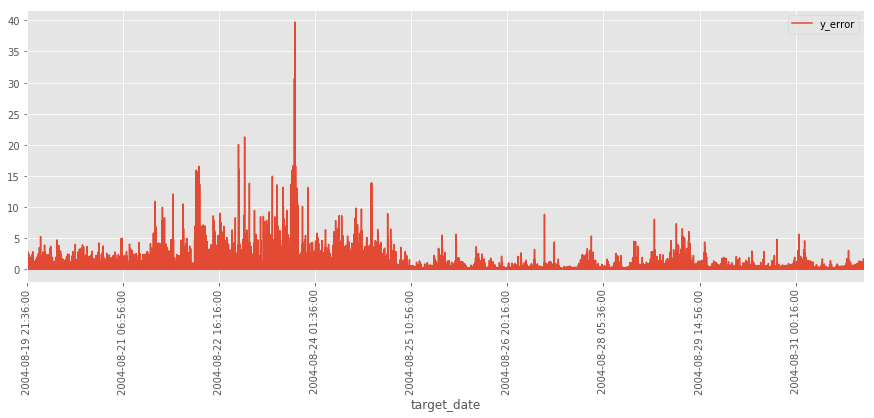

In [29]:
df_target[['y_error']].plot(figsize=(15,5), rot=90)

In [30]:
df_target

,target,predicted,bias,y_error
target_date,,,,
2004-08-19 21:36:00,11.7,11.223547,0.476453,0.227008
2004-08-19 21:37:00,12.2,11.491558,0.708442,0.501890
2004-08-19 21:38:00,11.2,12.073399,-0.873399,0.762825
2004-08-19 21:39:00,10.2,11.319760,-1.119760,1.253862
2004-08-19 21:40:00,10.1,10.838829,-0.738829,0.545869
2004-08-19 21:41:00,9.8,10.767662,-0.967662,0.936370
2004-08-19 21:42:00,9.4,10.129004,-0.729004,0.531447
2004-08-19 21:43:00,10.8,9.832145,0.967855,0.936744
2004-08-19 21:44:00,10.8,10.604444,0.195556,0.038242
